In [215]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [217]:
df = pd.read_csv('customers.csv')
df.rename(columns={'Unnamed: 0':'person'},inplace=True)
df.head()

,person,age,amount_spent_total,became_member_on,bogo_count_completed,bogo_count_received,bogo_count_viewed,bogo_spent_in_offer,bogo_sum_reward,discount_count_completed,discount_count_received,discount_count_viewed,discount_spent_in_offer,discount_sum_reward,gender,income,informational_count_completed,informational_count_received,informational_count_viewed,informational_spent_in_offer,informational_sum_reward
0,0610b486422d4921ae7d2bf64640c50b,55,77.01,20170715,1.0,1.0,0.0,0.00,5.0,0.0,0.0,0.0,0.00,0.0,F,112000.0,0.0,1.0,0.0,0.00,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,75,159.27,20170509,3.0,3.0,3.0,41.61,20.0,0.0,0.0,0.0,0.00,0.0,F,100000.0,1.0,1.0,1.0,49.39,0.0
2,e2127556f4f64592b11af22de27a7932,68,57.73,20180426,1.0,1.0,1.0,18.42,5.0,1.0,2.0,2.0,18.42,2.0,M,70000.0,0.0,1.0,0.0,0.00,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,58,15.62,20171111,0.0,0.0,0.0,0.00,0.0,1.0,2.0,2.0,12.43,2.0,M,51000.0,0.0,1.0,0.0,0.00,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,61,85.55,20170911,3.0,3.0,3.0,24.89,25.0,0.0,1.0,1.0,0.00,0.0,F,57000.0,1.0,1.0,1.0,0.00,0.0


transform the became_member_on column into a column that lets us know about how long someone is a member already. It seems appropriate to set the Year of the oldest membership to the base year.

In [218]:
def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)

In [219]:
df['became_member_on'] = df['became_member_on'].apply(lambda x:datetime.strptime(str(x),'%Y%m%d'))
base_time = df['became_member_on'].min()
df['member_since_month'] = df.apply(lambda x:month_diff(x['became_member_on'],base_time),axis = 1)
df.drop('became_member_on',axis=1,inplace=True)

In [220]:
df['count_all_offers_received'] = df.bogo_count_received + df.discount_count_received + df.informational_count_received
df['count_all_offers_viewed'] = df.bogo_count_viewed + df.discount_count_viewed + df.informational_count_viewed

In [221]:
df.columns

Index(['person', 'age', 'amount_spent_total', 'bogo_count_completed',
       'bogo_count_received', 'bogo_count_viewed', 'bogo_spent_in_offer',
       'bogo_sum_reward', 'discount_count_completed',
       'discount_count_received', 'discount_count_viewed',
       'discount_spent_in_offer', 'discount_sum_reward', 'gender', 'income',
       'informational_count_completed', 'informational_count_received',
       'informational_count_viewed', 'informational_spent_in_offer',
       'informational_sum_reward', 'member_since_month',
       'count_all_offers_received', 'count_all_offers_viewed'],
      dtype='object')

In [222]:
offers = ['bogo','discount','informational']
for offer in offers:
    df[offer+'_view_ratio'] =  df[offer+'_count_completed']/df['count_all_offers_viewed'] 
    df[offer+'_receive_ratio'] =  df[offer+'_count_completed']/df['count_all_offers_received'] 
    df.drop([offer+'_count_viewed',offer+'_count_received',offer+'_count_completed'],axis=1,inplace=True)
df.sort_index(axis=1,  inplace=True)

instead of string information about being male, female or other lets create a one-hot-encoding. to avoud linear dependency column of other is omitted

In [223]:
df = pd.concat([df, pd.get_dummies(df.gender)[['F','M']]],axis=1)
df.drop('gender',axis=1,inplace=True)

In [224]:
criteria = ['view','receive']
ratio_columns = [offer+'_'+crit+'_ratio' for offer in offers for crit in criteria] 

In [225]:
df =df[['person','age',   'F', 'M','member_since_month','income','count_all_offers_received', 'amount_spent_total', 
        'bogo_receive_ratio', 'bogo_spent_in_offer', 'bogo_sum_reward', 'bogo_view_ratio',
        'discount_receive_ratio', 'discount_spent_in_offer', 'discount_sum_reward', 'discount_view_ratio',
       'informational_receive_ratio', 'informational_spent_in_offer','informational_sum_reward', 'informational_view_ratio',
       ]]

we produced a few entries of np.inf and np.nan by deviding throu the count of offers viewed. since a person who doesnt view an offer cannot acitvely complete it, we eliminate these

In [228]:
df.dropna(inplace=True)

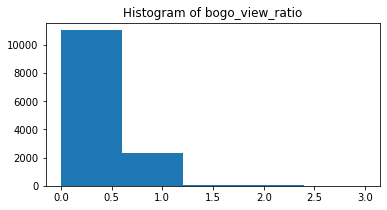

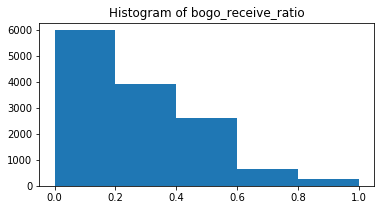

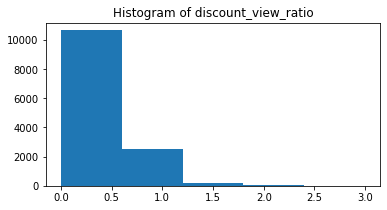

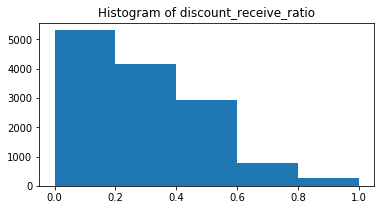

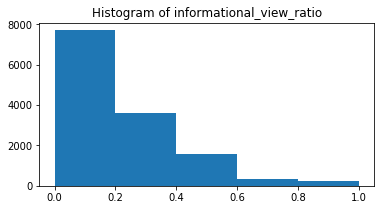

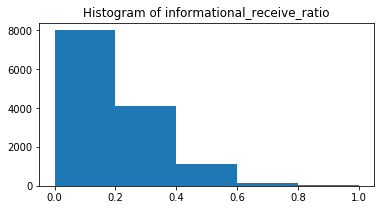

In [230]:
n_bins = 5
for column_name in ratio_columns:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(df[column_name], bins=n_bins)
    title="Histogram of " + column_name
    plt.title(title, fontsize=12)
    plt.show()
